In [8]:
from datetime import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

import skforecast
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster
import shap

In [9]:
ts= pd.read_csv('../../data/ts_top100_prediction.csv')

In [10]:
print(ts.shape)
ts.sample(1)

(1739323, 6)


,date,id,item,sales,income,event
701948,2013-06-07,SUPERMARKET_3_473_PHI_2,SUPERMARKET_3_473,3,13.968,0


In [11]:
ts['date']= pd.to_datetime(ts['date'], format='%Y-%m-%d')

In [12]:
ts['weekday'] = ts['date'].dt.day_name()

In [13]:
ts.sample(5)

,date,id,item,sales,income,event,weekday
1640194,2016-01-16,SUPERMARKET_3_473_PHI_2,SUPERMARKET_3_473,2,10.032,0,Saturday
851808,2013-11-11,HOME_&_GARDEN_1_027_BOS_3,HOME_&_GARDEN_1_027,1,7.050,0,Monday
56347,2011-04-26,SUPERMARKET_3_516_NYC_2,SUPERMARKET_3_516,1,3.576,0,Tuesday
1413222,2015-06-03,SUPERMARKET_3_136_PHI_1,SUPERMARKET_3_136,3,15.984,0,Wednesday
1254152,2014-12-26,SUPERMARKET_3_499_NYC_2,SUPERMARKET_3_499,9,27.000,0,Friday


In [14]:
ts = ts[ts['item']=='SUPERMARKET_3_586']

In [16]:
resultados = []

# Copy origina DataFrame
df_original = ts.copy()

dataset = df_original[['item','date','income','weekday','event']]
df_product = dataset[dataset['item']=='SUPERMARKET_3_586']
df_product_sin_duplicates = df_product[['date','weekday', 'event']].drop_duplicates()
ts_predict = df_product.groupby(['date'])['income'].sum().reset_index()
ts_predict = ts_predict.merge(df_product_sin_duplicates, on=['date'], how='left')
ts_predict = pd.get_dummies(data=ts_predict, columns=['weekday'], dtype=int)
ts_predict['date'] = pd.to_datetime(ts_predict['date'])
ts_predict.sort_values('date', ascending=True, inplace=True)
ts_predict.set_index('date', inplace=True)
steps = 30
ts_predict = ts_predict.asfreq('D')
y, exog = ts_predict['income'], ts_predict.drop(columns=['income'])
y_train, y_test = y[:-steps], y[-steps:]
exog_train, exog_test = exog[:-steps], exog[-steps:]        
forecaster = ForecasterAutoreg(
        regressor = RandomForestRegressor(random_state=123,
                                        max_depth=None,
                                        min_samples_leaf=1, 
                                        min_samples_split=2,
                                        n_estimators=50),
        lags=14
)
     
# Prepare for prediction(next mounth)
start_date = '2016-04-25' 
end_date ='2016-05-30'
# Create range date
date_range = pd.date_range(start=start_date, end=end_date)
# Create DataFrame
df1 = pd.DataFrame(date_range, columns=['date'])
df1['date'] = pd.to_datetime(df1['date'])
df1['weekday'] = df1['date'].dt.day_name()
df1['event'] = 0
df1 = pd.get_dummies(data=df1, columns=['weekday'], dtype=int)
df1.sort_values('date', inplace=True, ascending=True)
df1.set_index('date', inplace=True)
df1 = df1.asfreq('D')
exog_test = pd.concat([exog_test, df1], ignore_index=False)
forecaster.fit(y=y_train, exog=exog_train)
predictions = forecaster.predict(steps=30, exog=exog_test).to_list()
resultados.append({'prediction':predictions,'test':y_test.values})

In [17]:
pd.DataFrame(resultados)

,prediction,test
0,"[998.7158399999996, 1020.41616, 771.78432, 715...","[1280.16, 1167.264, 683.424, 584.64, 604.8, 66..."


In [18]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = y_test,
                y_pred = predictions
            )
print(f"Test error (MSE): {error_mse}")
rmspe = np.sqrt(np.mean(((y_test - predictions) / y_test) ** 2)) * 100

Test error (MSE): 9132.155026421757


In [19]:
result = pd.DataFrame(predictions, columns=['prediction'])

In [20]:
result['date'] = pd.DataFrame(list(y_test.index.values))

In [21]:
result.set_index('date', inplace=True)

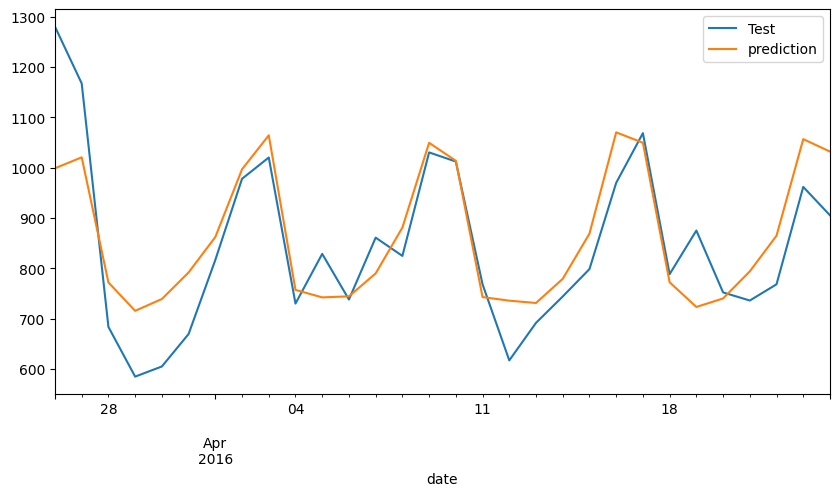

In [22]:
fig, ax = plt.subplots(figsize=(10, 5))
y_test[-30:].plot(ax=ax, label='Test')
result.plot(ax=ax, label='Predictions')
ax.legend()
plt.show()